# Anomalous Financial Transaction Detection

본 대회의 과제는 금융 거래 데이터에서 **이상 거래를 탐지하는 기능**을 개선하고 활용도를 높이는 분류 AI모델을 개발하는 것입니다. 

특히, 클래스 불균형 문제를 해결하기 위해 오픈소스 생성형 AI 모델을 활용하여 부족한 클래스의 데이터를 보완하고, 이를 통해 분류 모델의 성능을 향상시키는 것이 핵심 목표입니다. 

이러한 접근을 통해 금융보안에 특화된 데이터 분석 및 활용 역량을 강화하여 전문 인력을 양성하고, 금융권의 AI 활용 어려움에 따른 해결 방안을 함께 모색하며 금융 산업의 AI 활용 활성화를 지원하는 것을 목표로 합니다.


# 전략

## 1. 좋은 학습 데이터 생성(생성형 AI)

- 좋은 생성 데이터 : 원본 데이터랑 겹치지 않는 데이터 (특정 열의 값이 같은 경우, 나머지 값들도 같은 경우가 적은 상태)
    - 생성형 AI 모델 비교 및 선택
        - ctgan, tvae
        - ctab-ga, g-ctgan, vaem : 논문 참고해 구현 필요

    - 생성형 AI 데이터 비율 조정해보기

## 2. 이상치 처리 

- z-score 
    - 다른 분포로 가정해보기 (KDE로 분포 찾기?)

## 3. 좋은 분류 모델

xgboost - baseline

- 딥러닝 모델 :  tabnet(특성 중요도 표시 가능), wide&deep(추천시스템)
- 로지스틱 회귀
- 다양한 분류 모델 짬뽕 (multiple classifier system)
- 머신러닝 모델 : xgboost, adaboost, ...

## 4.  특성 공학

- 데이터 처리
    - 데이터 정규화 (z-score 이용하는게 좋은 듯. test 데이터에서 이상치 발생할 수 있으므로)

- 특성 재조립
    - 마지막 영업점 / ATM 거래 일자 차이
    - 거래발생 위치 -> 시군구 분리 후 특성으로 활용
    - 범주의 개수가 3개 이상인 데이터들은 ordinal 이 아닌 군집화 후 one hot vector 로 변환

## 5. 기타 금융 이상거래 도메인 지식

- 특징?

In [1]:
# Import Library
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

# 머신러닝 전처리
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

# 분류 모델
import xgboost as xgb

# 합성 데이터 생성
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sklearn.preprocessing import KBinsDiscretizer

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')




# 데이터 전처리

In [2]:

# 생성 🏭
# Load Data
train_all = pd.read_csv("./train.csv")
test_all = pd.read_csv("./test.csv")
train = train_all.drop(columns="ID")
train["Fraud_Type"].value_counts()
'''
(*) 리더보드 산식 중 생성데이터의 익명성(TCAP)채점을 위해 각 클래스 별로 1000개의 생성데이터가 반드시 필요합니다.
(*) 본 베이스 라인에서는 "Fraud_Type" 13종류에 대해 1000개씩 , 총 13,000개의 데이터를 생성할 예정입니다.
(*) 분류 모델 성능 개선을 위해 생성 데이터를 활용하는 것에는 생성 데이터의 Row 개수에 제한이 없습니다. 단, 리더보드 평가를 위해 제출을 하는 생성 데이터 프레임은 익명성(TCAP) 평가를 위함이며, 위의 조건을 갖춘 생성 데이터를 제출해야합니다.
'''

'\n(*) 리더보드 산식 중 생성데이터의 익명성(TCAP)채점을 위해 각 클래스 별로 1000개의 생성데이터가 반드시 필요합니다.\n(*) 본 베이스 라인에서는 "Fraud_Type" 13종류에 대해 1000개씩 , 총 13,000개의 데이터를 생성할 예정입니다.\n(*) 분류 모델 성능 개선을 위해 생성 데이터를 활용하는 것에는 생성 데이터의 Row 개수에 제한이 없습니다. 단, 리더보드 평가를 위해 제출을 하는 생성 데이터 프레임은 익명성(TCAP) 평가를 위함이며, 위의 조건을 갖춘 생성 데이터를 제출해야합니다.\n'

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 63 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Customer_Birthyear                             120000 non-null  int64  
 1   Customer_Gender                                120000 non-null  object 
 2   Customer_personal_identifier                   120000 non-null  object 
 3   Customer_identification_number                 120000 non-null  object 
 4   Customer_registration_datetime                 120000 non-null  object 
 5   Customer_credit_rating                         120000 non-null  object 
 6   Customer_flag_change_of_authentication_1       120000 non-null  int64  
 7   Customer_flag_change_of_authentication_2       120000 non-null  int64  
 8   Customer_flag_change_of_authentication_3       120000 non-null  int64  
 9   Customer_flag_change_of_authenticatio

In [4]:
obj_cat_columns=[col for col in train.select_dtypes(['object']).columns if train[col].nunique() <= 20]
obj_idf_columns=[col for col in train.select_dtypes(['object']).columns if train[col].nunique() >= 20]
num_cat_columns=[col for col in train.select_dtypes(['int64', 'float64']).columns if train[col].nunique() <= 20]
num_con_columns=[col for col in train.select_dtypes(['int64', 'float64']).columns if train[col].nunique() >= 20]

obj_cat_columns.remove('Fraud_Type')

In [5]:
print('obj_cat_columns : ', obj_cat_columns)
print('obj_idf_columns : ', obj_idf_columns)
print('num_cat_columns : ', num_cat_columns)
print('num_con_columns : ', num_con_columns)

obj_cat_columns :  ['Customer_Gender', 'Customer_credit_rating', 'Customer_loan_type', 'Account_account_type', 'Channel', 'Operating_System', 'Error_Code', 'Type_General_Automatic', 'Access_Medium']
obj_idf_columns :  ['Customer_personal_identifier', 'Customer_identification_number', 'Customer_registration_datetime', 'Account_account_number', 'Account_creation_datetime', 'Transaction_Datetime', 'IP_Address', 'MAC_Address', 'Location', 'Recipient_Account_Number', 'Time_difference', 'Last_atm_transaction_datetime', 'Last_bank_branch_transaction_datetime', 'Transaction_resumed_date']
num_cat_columns :  ['Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3', 'Customer_flag_change_of_authentication_4', 'Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator', 'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_term

In [6]:

# 이상치 처리 함수
def handle_outliers(series, n_std=3):
    mean = series.mean()
    std = series.std()
    z_scores = np.abs(stats.zscore(series))
    # 단순히 평균으로 바꾸는 대신....아예 제거하지 말거나 중위값?
    # 이상치는 대부분 m 카테고리?
    return series.mask(z_scores > n_std, mean)


# Time_difference 컬럼을 총 초로 변환 및 이상치 처리
train['Time_difference_seconds'] = pd.to_timedelta(train['Time_difference']).dt.total_seconds()
train['Time_difference_seconds'] = handle_outliers(train['Time_difference_seconds'])

# KNN 군집 데이터 추가



# EDA

In [7]:
def eda_graph(df, columns, dtype, ncol=5):
    nrow=len(columns)//ncol+1
    
    if nrow==0:
        if dtype=='cat':
            _, axes= plt.subplots(1, ncol, figsize=(ncol*10,  nrow*3))
            for i, col in enumerate(columns):
                sns.countplot(data=df, x=col, ax=axes[i])
        else:
            for i, col in enumerate(columns):
                sns.displot(df[col])
    else:            
        if dtype=='cat':
            _, axes= plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*3))
            for i, col in enumerate(columns):
                sns.countplot(data=df, x=col, ax=axes[i//ncol, i%ncol])
        else:
            for i, col in enumerate(columns):
                sns.displot(df[col])
                
    plt.tight_layout()

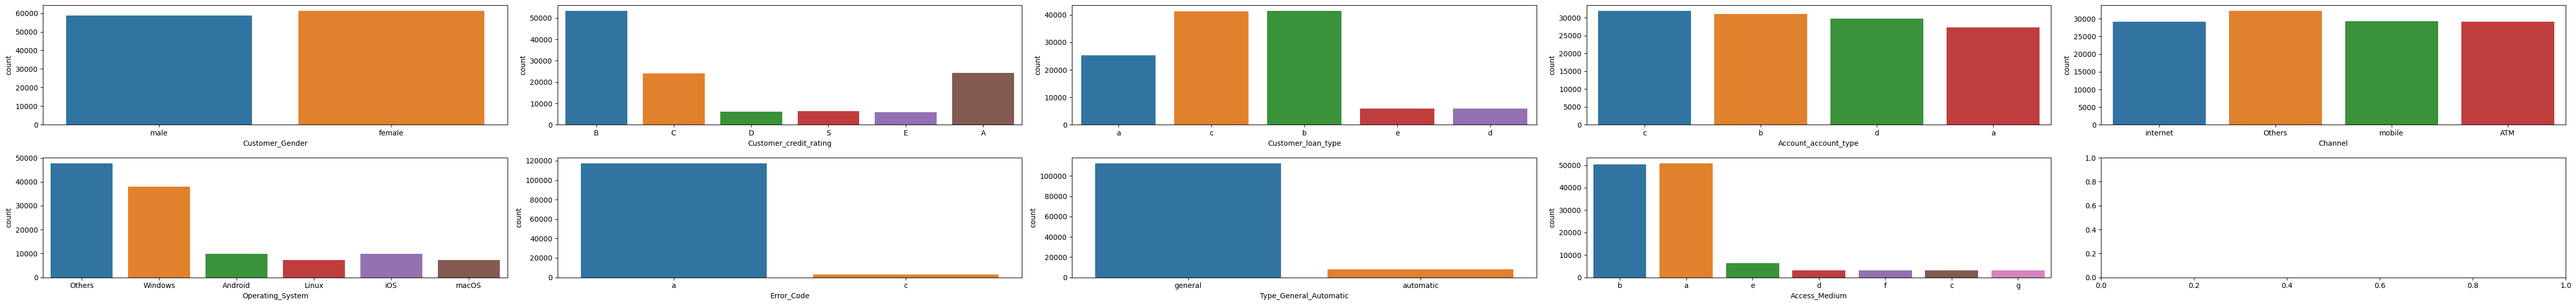

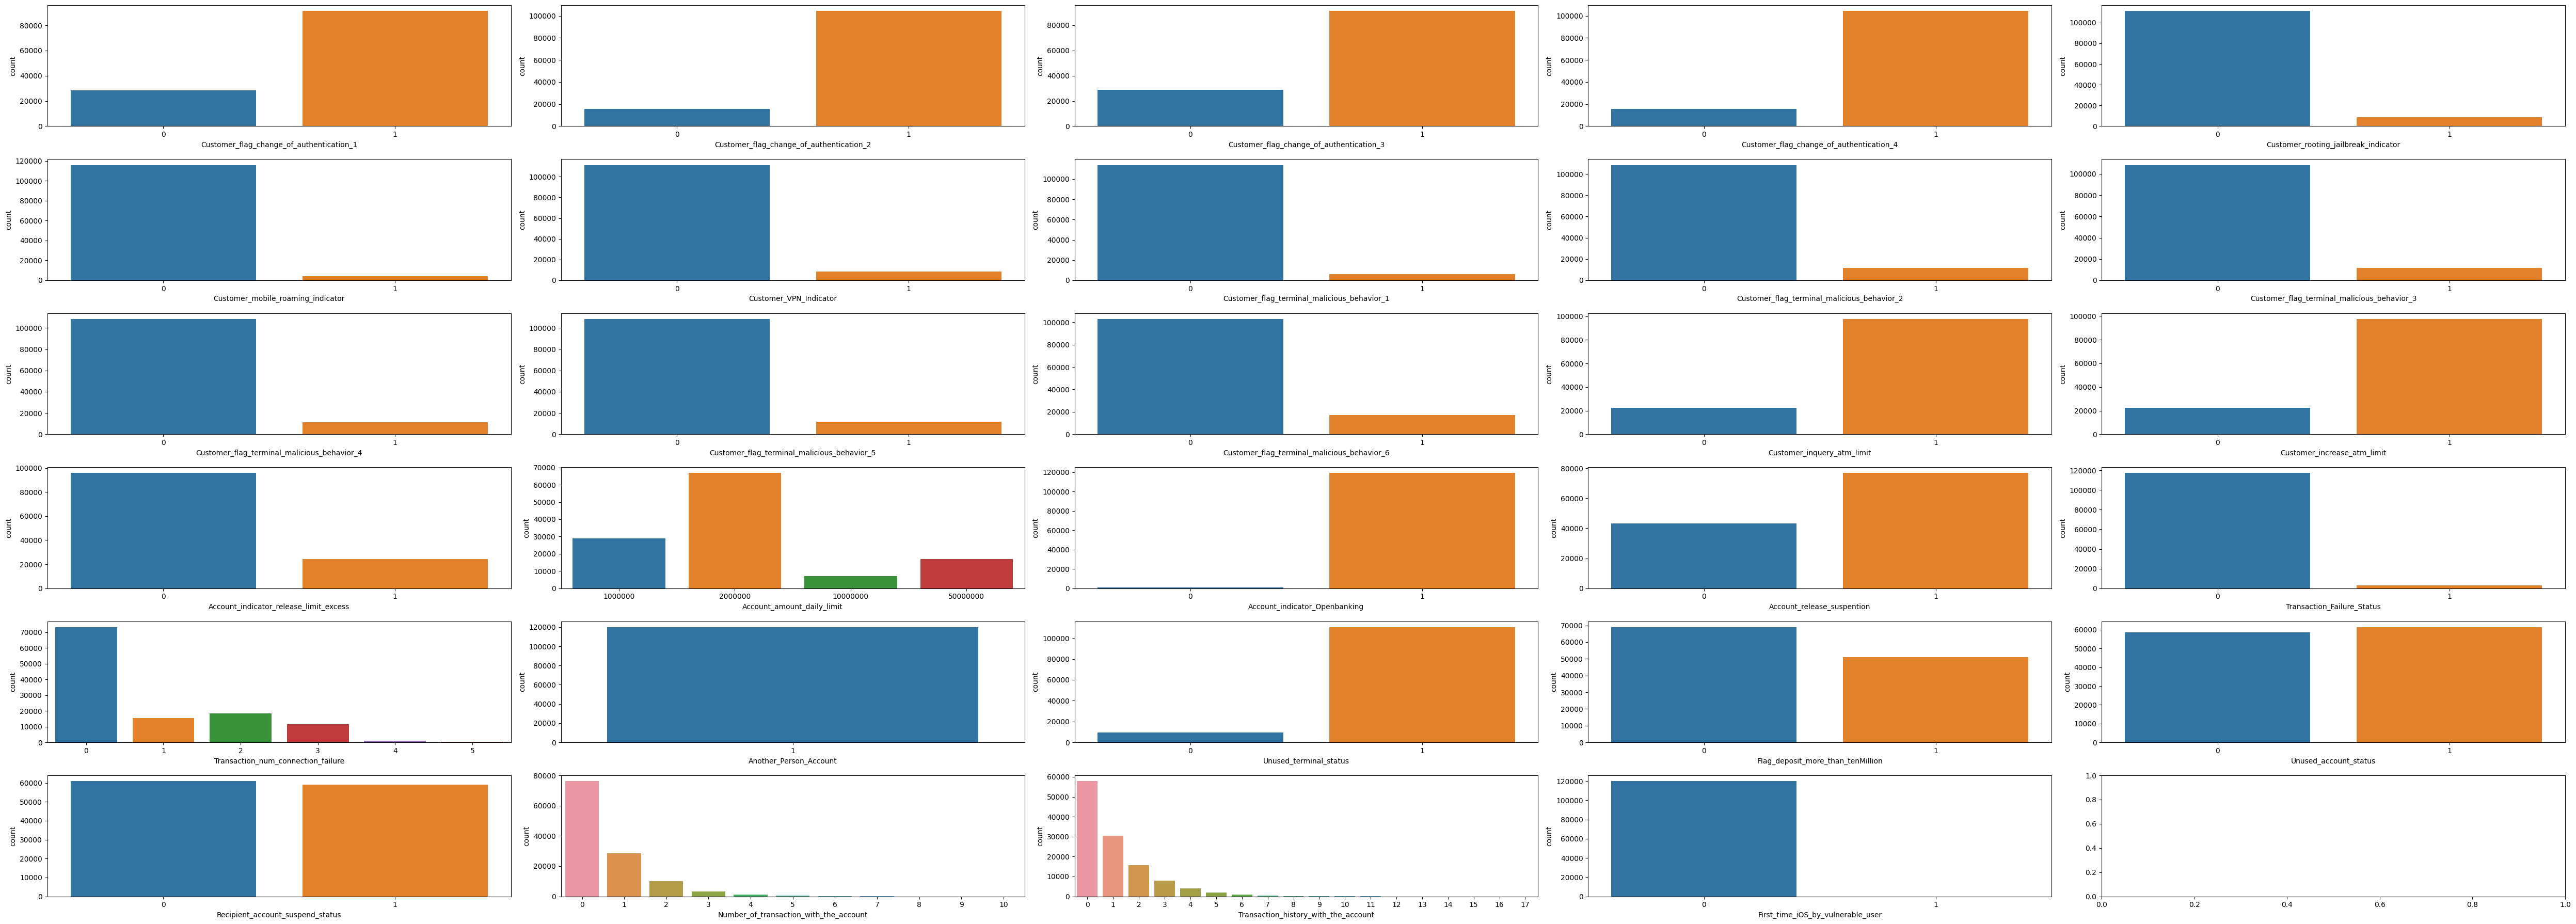

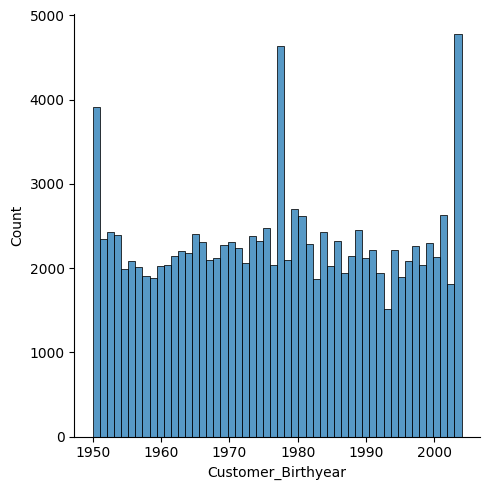

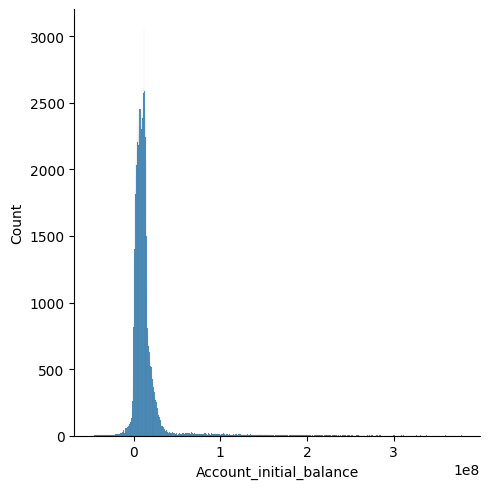

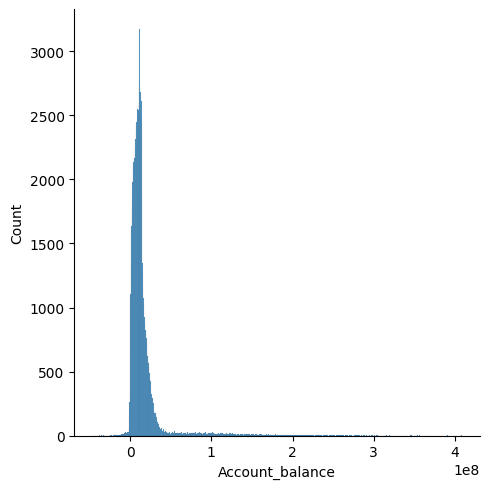

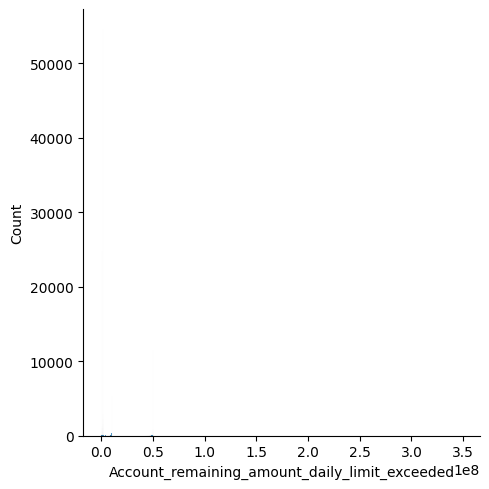

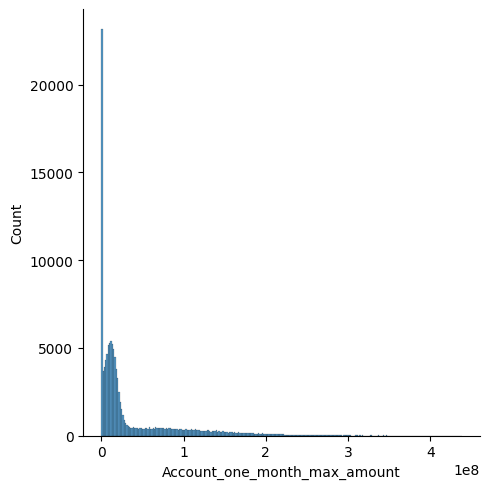

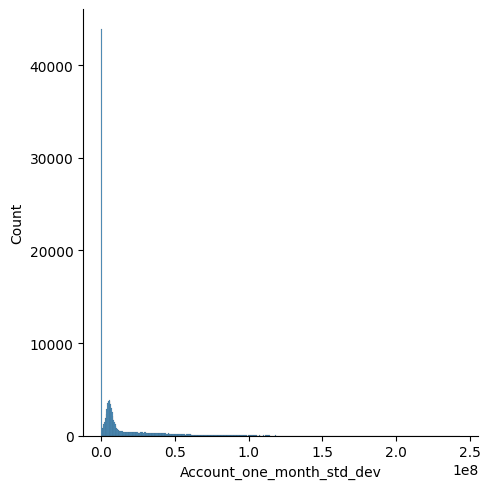

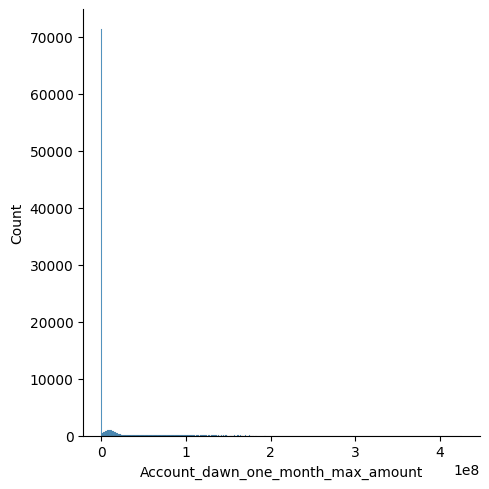

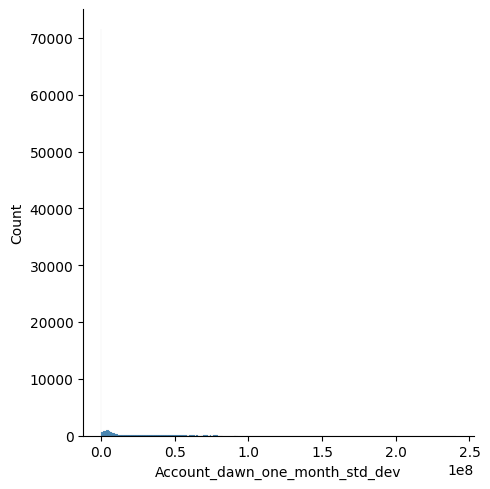

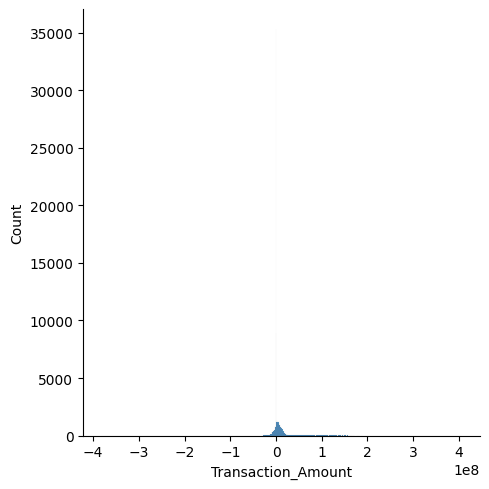

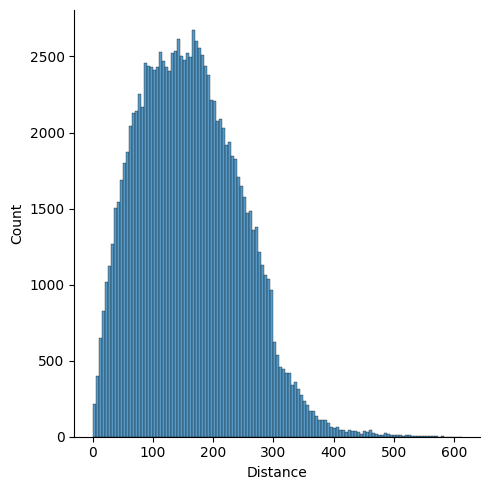

In [8]:
eda_graph(train, obj_cat_columns, dtype='cat')
eda_graph(train, num_cat_columns, dtype='cat')
eda_graph(train, num_con_columns, dtype='con')

In [9]:
train['Fraud_Type'].value_counts()

Fraud_Type
m    118800
a       100
j       100
h       100
k       100
c       100
g       100
i       100
b       100
f       100
d       100
e       100
l       100
Name: count, dtype: int64

# 데이터 생성

In [10]:
# 모든 Fraud_Type 목록 생성 (m 포함)
fraud_types = train['Fraud_Type'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data = pd.DataFrame()

N_CLS_PER_GEN = 1000
N_SAMPLE = 100


# 각 Fraud_Type에 대해 합성 데이터 생성 및 저장
for fraud_type in tqdm(fraud_types):
    
    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = train[train["Fraud_Type"] == fraud_type]

    # 모든 Fraud_Type에 대해 100개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)
    
    # Time_difference 열 제외 (초 단위로 변환된 컬럼만 사용)
    subset = subset.drop('Time_difference', axis=1)
    
    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    # 데이터 타입 설정
    column_sdtypes = {
        'Account_initial_balance': 'numerical',
        'Account_balance': 'numerical',
        'Customer_identification_number': 'categorical',  
        'Customer_personal_identifier': 'categorical',
        'Account_account_number': 'categorical',
        'IP_Address': 'ipv4_address',  
        'Location': 'categorical',
        'Recipient_Account_Number': 'categorical',
        'Fraud_Type': 'categorical',
        'Time_difference_seconds': 'numerical',
        'Customer_Birthyear': 'numerical'
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )
        
    synthesizer = TVAESynthesizer(
                            metadata,
                            epochs=100
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)
    
    # 생성된 Time_difference_seconds의 이상치 처리
    synthetic_subset['Time_difference_seconds'] = handle_outliers(synthetic_subset['Time_difference_seconds'])
    
    # Time_difference_seconds를 다시 timedelta로 변환
    synthetic_subset['Time_difference'] = pd.to_timedelta(synthetic_subset['Time_difference_seconds'], unit='s')
    
    # Time_difference_seconds 컬럼 제거
    synthetic_subset = synthetic_subset.drop('Time_difference_seconds', axis=1)
    
    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data = pd.concat([all_synthetic_data, synthetic_subset], ignore_index=True)
    


100%|██████████| 13/13 [00:55<00:00,  4.25s/it]


In [11]:
# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data.shape)

## 원본 데이터와 concat
origin_train = train_all.drop(columns="ID")
train_total = pd.concat([origin_train, all_synthetic_data])
train_total.shape

# 불균형 범주형 데이터 교차검증
fold_num=5
f1_macro_sum=0
skf=StratifiedKFold(n_splits=fold_num)
for i, (train_index, valid_index) in enumerate(skf.split(train_total, train_total['Fraud_Type'])):

    # Data Preprocessing 1 : Select x, y
    train_x = train_total.iloc[train_index].drop(columns=['Fraud_Type'])
    train_y = train_total.iloc[train_index]['Fraud_Type']
    
    valid_x = train_total.iloc[valid_index].drop(columns=['Fraud_Type'])
    valid_y = train_total.iloc[valid_index]['Fraud_Type']

    # Data Preprocessing 2 : 범주형 변수 인코딩
    le_subclass = LabelEncoder()
    train_y_encoded = le_subclass.fit_transform(train_y)
   
    train_x['Time_difference'] = train_x['Time_difference'].astype(str)
    valid_x['Time_difference'] = valid_x['Time_difference'].astype(str)

    # 범주형 변수 인코딩

    ct=ColumnTransformer([('encoder', OneHotEncoder(sparse=False, drop='first',handle_unknown='ignore'), obj_cat_columns+num_cat_columns),
                        ('scaler', StandardScaler(), num_con_columns)]
                             )
 
    # 훈련 데이터 인코딩
    train_x_encoded = train_x.copy()
    valid_x_encoded = valid_x.copy()
    
    train_encoded_array=ct.fit_transform(train_x_encoded)
    valid_encoded_array=ct.transform(valid_x_encoded)
    
    column_names=ct.get_feature_names_out()
    train_x_encoded=pd.DataFrame(train_encoded_array, columns=column_names)
    valid_x_encoded=pd.DataFrame(valid_encoded_array, columns=column_names)
        
    # Model Define
    # 모델 정의 및 학습
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    model.fit(train_x_encoded, train_y_encoded)

    predictions = model.predict(valid_x_encoded)
    predictions_label = le_subclass.inverse_transform(predictions)
    
    f1_macro=f1_score(valid_y, predictions_label, average='macro')
    print(f'Fold {i} Macro F1 Score : {f1_macro}')

    f1_macro_sum+=f1_macro
    
print(f'Average Macro F1 Score : {f1_macro_sum/fold_num}')



Final All Synthetic Data Shape: (13000, 63)
Fold 0 Macro F1 Score : 0.7202792254437705
Fold 1 Macro F1 Score : 0.9862628913668777
Fold 2 Macro F1 Score : 0.9861442431586129
Fold 3 Macro F1 Score : 0.9845120421575485
Fold 4 Macro F1 Score : 0.97361614500341
Average Macro F1 Score : 0.930162909426044


# 모델 예측

In [12]:
# 테스트 데이터 인코딩
test_x=test_all.drop(columns=['ID'])
test_x_encoded = test_x.copy()
test_encoded_array=ct.transform(test_x_encoded)

# 특성 순서 맞추기 및 데이터 타입 일치
column_names=ct.get_feature_names_out()
test_x_encoded=pd.DataFrame(test_encoded_array, columns=column_names)

# 예측
predictions = model.predict(test_x_encoded)
predictions_label = le_subclass.inverse_transform(predictions)

# 제출 파일 생성

In [13]:
# 분류 예측 결과 제출 데이터프레임(DataFrame)

clf_submission = pd.read_csv("./sample_submission.csv")
clf_submission["Fraud_Type"] = predictions_label

# 폴더 생성 및 작업 디렉토리 변경
os.makedirs('./submission', exist_ok=True)
os.chdir("./submission/")

# CSV 파일로 저장
clf_submission.to_csv('./clf_submission.csv', encoding='UTF-8-sig', index=False)
all_synthetic_data.to_csv('./syn_submission.csv', encoding='UTF-8-sig', index=False)

# ZIP 파일 생성 및 CSV 파일 추가
with zipfile.ZipFile("../baseline_submission_v5.zip", 'w') as submission:
    submission.write('clf_submission.csv')
    submission.write('syn_submission.csv')
